# Prétraitement des données d'environnements

Ce notebook a servi de base afin de choisir les traitements à effectuer lors de la fusion de l'ensemble de nos données environnementales. Les tests ont été effectués ici, afin de ne pas surcharger le code du notebook de prétraitement de ces données. Des analyses y sont également faites, afin de décider ci les cellules avec des données manquantes doivent être supprimées ou non.

## Import des données

In [1]:
# Imports du notebook
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box
import os

In [2]:
def load_geodataframes(file_paths):
    """Charge plusieurs fichiers CSV en GeoDataFrames et les stocke dans un dictionnaire."""
    geodfs = {}
    for name, file_path in file_paths.items():
        df = pd.read_csv(file_path)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
        gdf.set_crs(epsg=2056, inplace=True)
        geodfs[name] = gdf
    return geodfs

In [3]:
def merge_geodataframes(geodfs):
    """Fusionne plusieurs GeoDataFrames en conservant toutes les entrées uniques en utilisant les noms relatifs pour les géométries."""
    # Initialiser avec le premier GeoDataFrame
    merged_gdf = geodfs.pop(next(iter(geodfs)))

   # Fusionner avec une jointure externe (outer join)
    for name, gdf in geodfs.items():
        merged_gdf = merged_gdf.merge(gdf, on='idx', how='outer', suffixes=('', f'_{name}_drop'))

    return merged_gdf

In [4]:
# Dictionnaire des chemins vers vos fichiers CSV avec un nom relatif
file_paths = {
    'alt' : '../../data/processed/processed_swiss_grid_altitude.csv', 
    'env' : '../../data/processed/processed_swiss_grid_environment.csv', 
    'apt' : '../../data/processed/processed_swiss_grid_soil_aptitude.csv',
    'tmp' : '../../data/processed/processed_swiss_grid_temperature.csv'
}

# Charger les GeoDataFrames
geodfs = load_geodataframes(file_paths)

# Fusionner les GeoDataFrames
merged_gdf = merge_geodataframes(geodfs)
merged_gdf.head()

,idx,geometry,altitude,geometry_env_drop,TypoCH_NUM,geometry_apt_drop,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,geometry_tmp_drop,temperature
0,33,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1107261.72, 2486071.58 11...",5.0
1,34,"POLYGON ((2485071.58 1108261.72, 2486071.58 11...",410.7500,None,NaN,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1108261.72, 2486071.58 11...",5.1
2,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",62.0,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...","orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",5.2
3,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",62.0,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...","orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",5.2
4,37,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",387.6868,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",12.0,None,NaN,NaN,NaN,NaN,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",5.2


## Traitement des données manquantes

La fusion des jeux de données entraine la présence de données manquantes, les limites n'étant pas exactement les mêmes dans les différents jeux de données.

In [5]:
merged_gdf[merged_gdf.isnull().T.any()].shape[0]

15282

### Cellules hors de la Suisse

Les cellules qui sont grandement hors de la Suisse sont facilement détectables : Il s'agit des cellules pour lesquelles il n'y a ni milieu naturel ni aptitudes du sol.

In [6]:
condition0 = (
    merged_gdf['geometry_env_drop'].isnull() &
    merged_gdf['geometry_apt_drop'].isnull()
)

In [7]:
merged_gdf.loc[condition0].shape[0]

15230

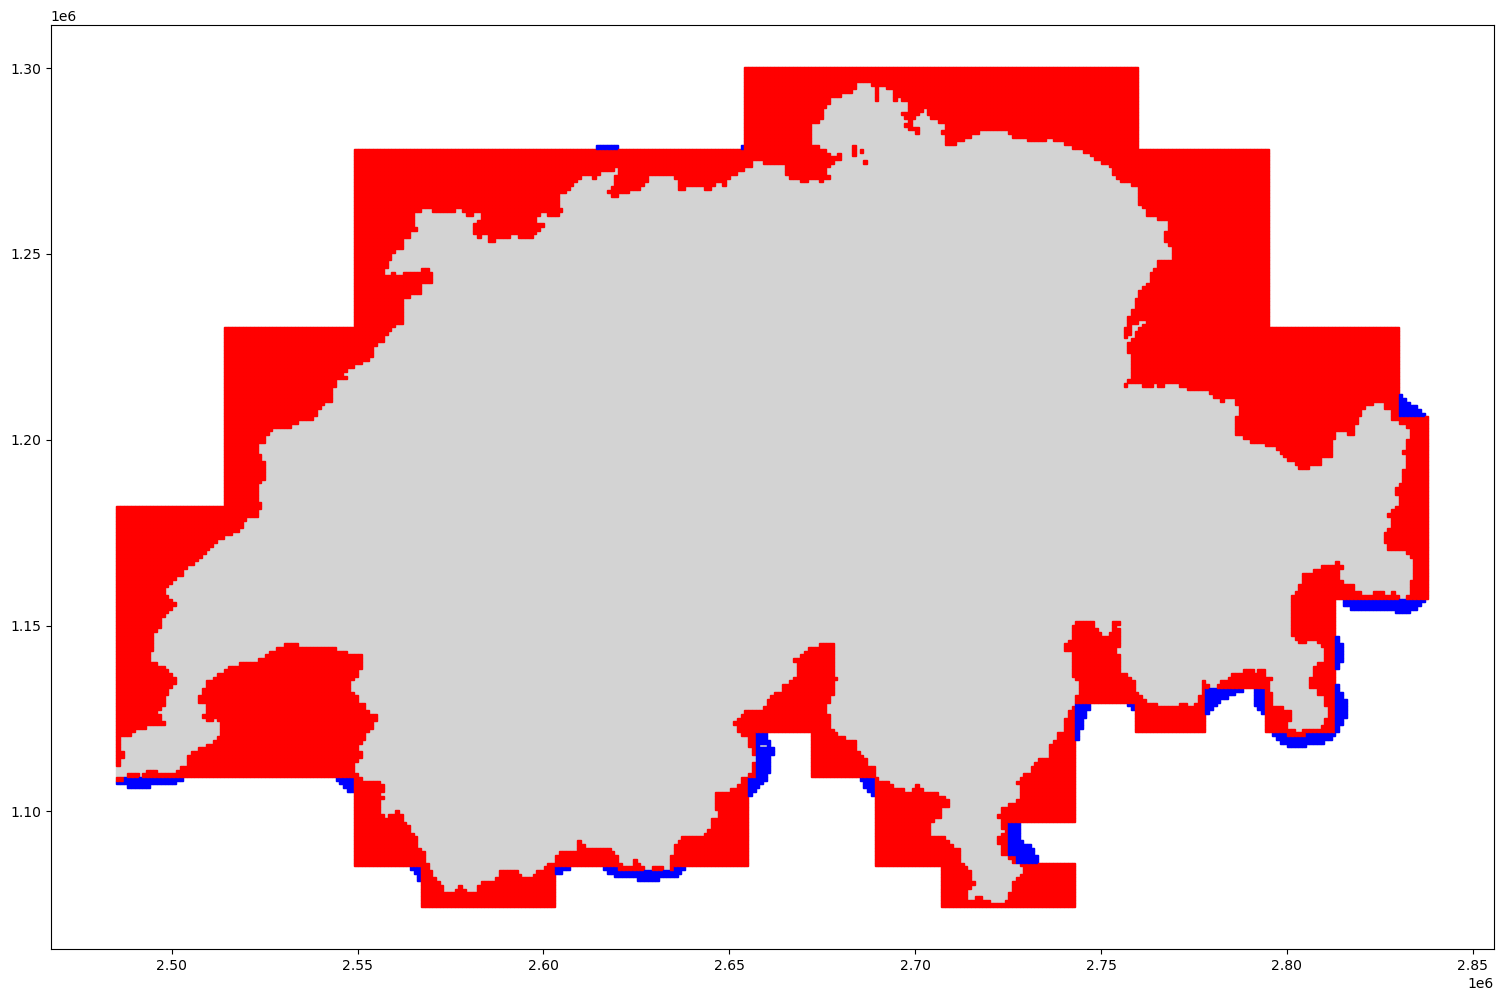

In [8]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    if row['geometry'] :
        polygon = row['geometry']
    else : 
        polygon = row['geometry_tmp_drop']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage en couleurs des données à corriger / supprimer
# En rouge les données possédant une altitude et en bleu celles n'en possédant pas
for idx, row in merged_gdf.loc[condition0].iterrows():
    if row['geometry'] :
        polygon = row['geometry']
        color = "red"
    else : 
        polygon = row['geometry_tmp_drop']
        color = "blue"
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

In [9]:
# Suppression des entrées pour lesquelles il n'y a pas de géométrie pour l'environnement et pour l'aptitude des sols
merged_gdf = merged_gdf.loc[~condition0]

### Cellules sans altitude

Les jeux de données utilisés ne sont pas sans failles et des données peuvent avoir été ajoutées malencontreusement. C'est sans doute le cas pour ces deux entrées, possédant un environnement, mais pas d'altitude ni d'aptitudes du sol. Le `TypoCH_NUM` indique que ces zones sont des voies de communication. L'altitude n'étant pas renseignée, il doit donc s'agir de positions bien en dehors de la Suisse. Nous avons pris les points de référence des géométries existantes et nous avons visualisé ces données directement sur la [carte de GeoAdmin](https://s.geo.admin.ch/9mb88x2if1v9). Il s'agit de voies ferrées, près de Trasquera en Italie.

In [10]:
condition1 = (
    merged_gdf['geometry'].isnull()
)

In [11]:
merged_gdf.loc[condition1]

,idx,geometry,altitude,geometry_env_drop,TypoCH_NUM,geometry_apt_drop,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,geometry_tmp_drop,temperature
27962,39141,None,NaN,"POLYGON ((2658071.58 1117261.72, 2659071.58 11...",93.0,None,NaN,NaN,NaN,NaN,"POLYGON ((2658071.58 1117261.72, 2659071.58 11...",-0.5
28154,39367,None,NaN,"POLYGON ((2659071.58 1117261.72, 2660071.58 11...",93.0,None,NaN,NaN,NaN,NaN,"POLYGON ((2659071.58 1117261.72, 2660071.58 11...",-0.1


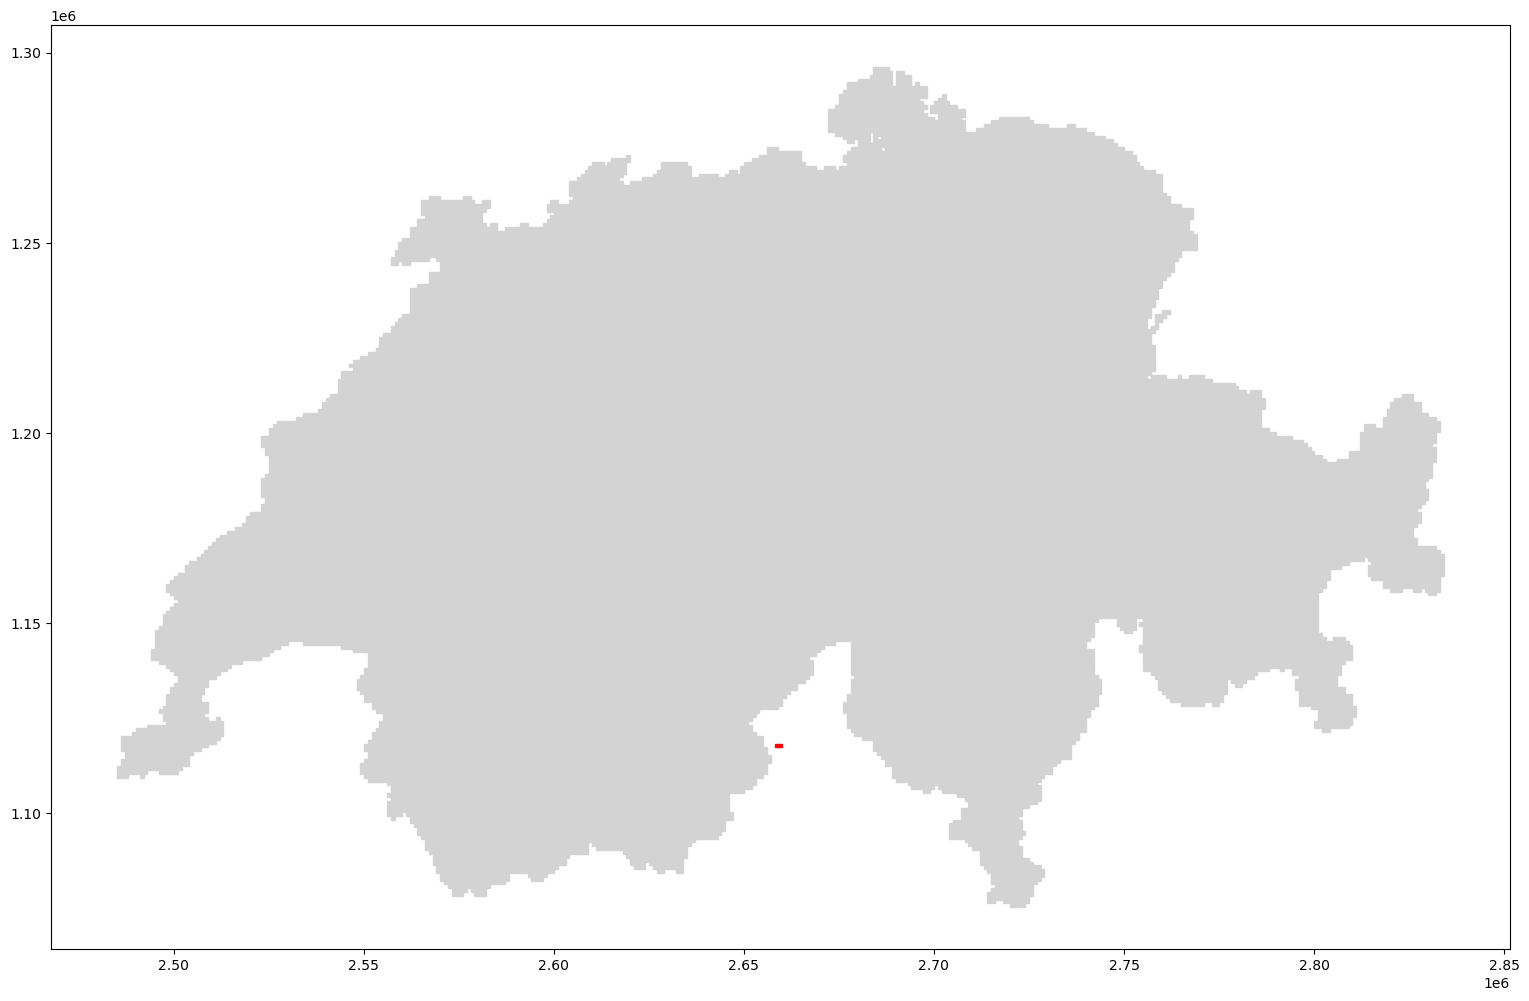

In [12]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
   if row['geometry'] :
        polygon = row['geometry']
        x, y = polygon.exterior.xy
        ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition1].iterrows():
    polygon = row['geometry_env_drop']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

In [13]:
merged_gdf = merged_gdf.loc[~condition1]

### Cellules sans milieu naturel et avec aptitudes du sol inconnues

Il s'avère qu'il y a des entrées pour lesquelles nous avons une aptitude des sols inconnue, mais existante tout de même, sans avoir d'information sur l'environnement. Il s'agit de zones dont les délimitations ne correspondent pas entièrement aux frontières suisses et débordent légèrement sur les pays limitrophes. Nous pouvons donc les supprimer sans impact pour notre analyse.

Une zone semble être manquante en plein territoire suisse, près de Schaffhouse, mais il s'agit en réalité d'une enclave allemande. Cette anomalie n'est donc pas non plus pertinente à conserver et nous pouvons également la supprimer sans impacts.

Note : Ces entrées montrent qu'une amélioration de la préparation des données sous forme d'une grille pourrait être améliorée, en utilisant une valeur seuil pour la surface minimale à avoir avant de considérer une cellule comme faisant partie de la Suisse. Si le temps le permet, cela sera mis en place et les données seront corrigées en conséquence.

In [14]:
condition2 = (
   merged_gdf['geometry_env_drop'].isnull() & 
   (merged_gdf['Bodentyp'] == '-') & 
   (merged_gdf['NAHRSTOFF'] == 0) & 
   (merged_gdf['WASSERDURC'] == 0) &
   (merged_gdf['WASSERSPEI'] == 0)
)

In [15]:
merged_gdf.loc[condition2].shape[0]

12

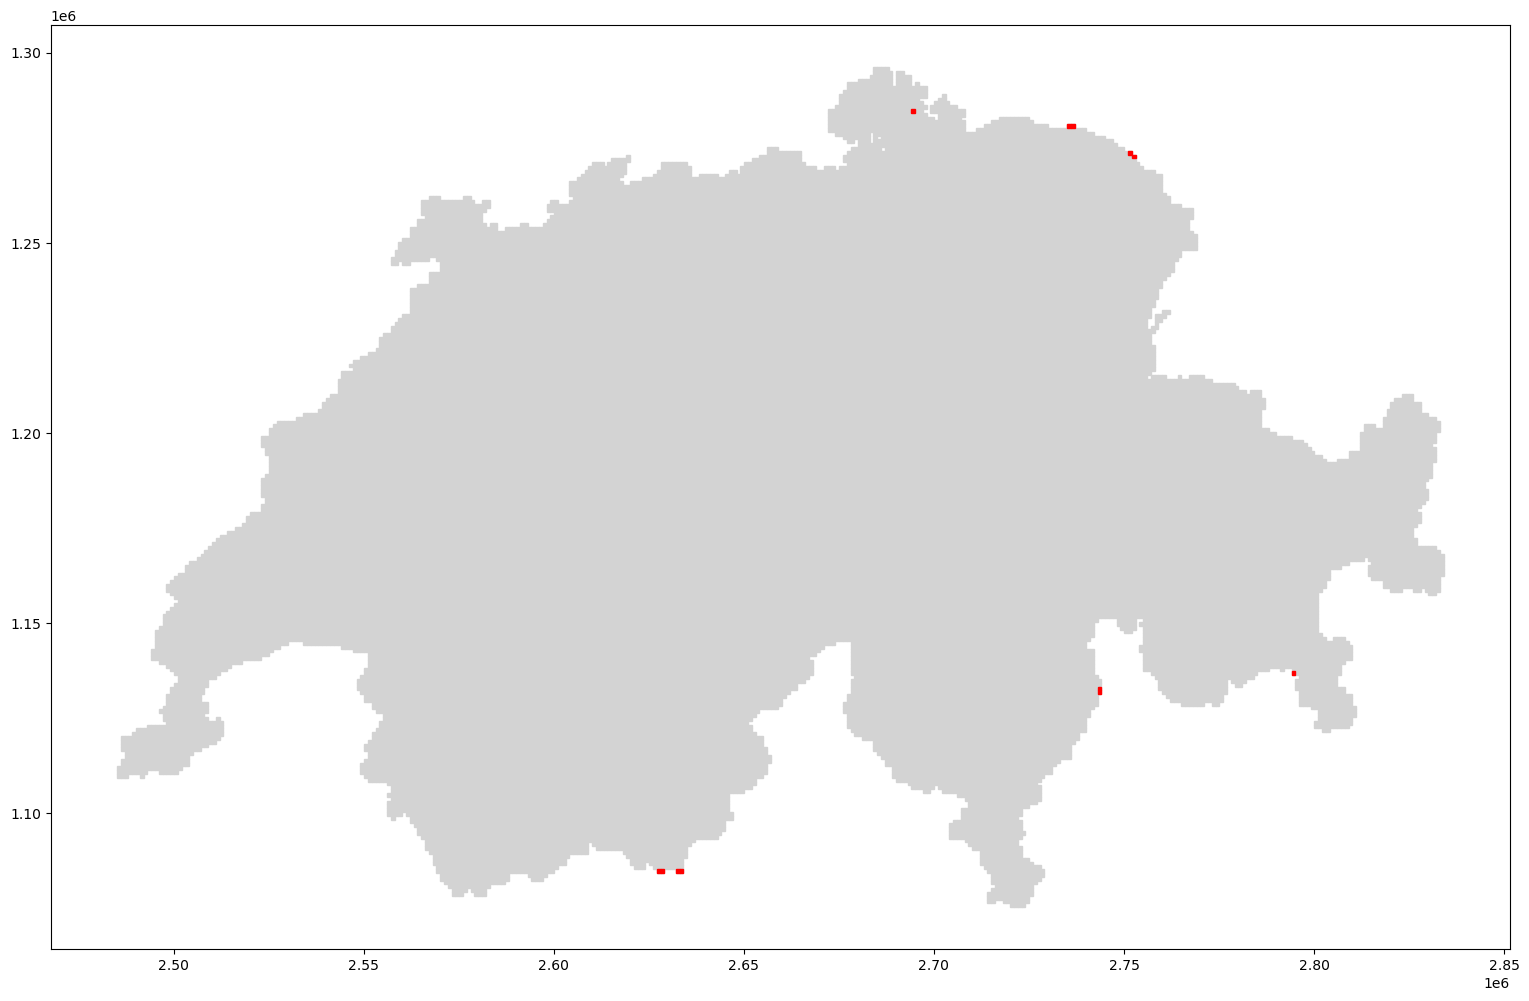

In [16]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition2].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

Il n'est pas facile de réellement savoir si ces données sont correctes ou un simple problème de bords mal définis. Les graphiques suivants montrent donc les différentes cellules avec la géométrie (ou plusieurs) qui a impacté la valeur de cette cellule.

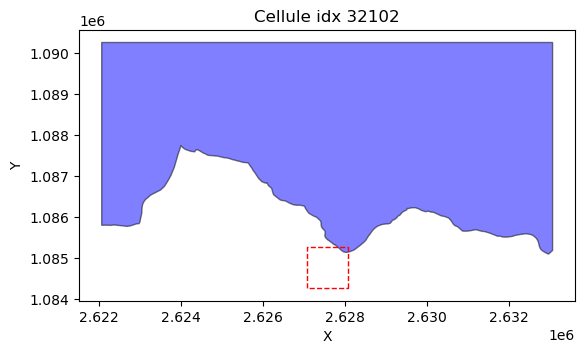

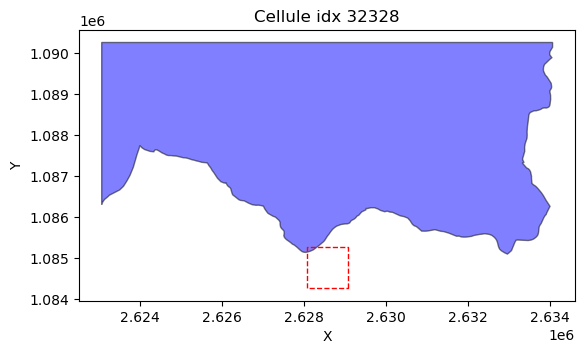

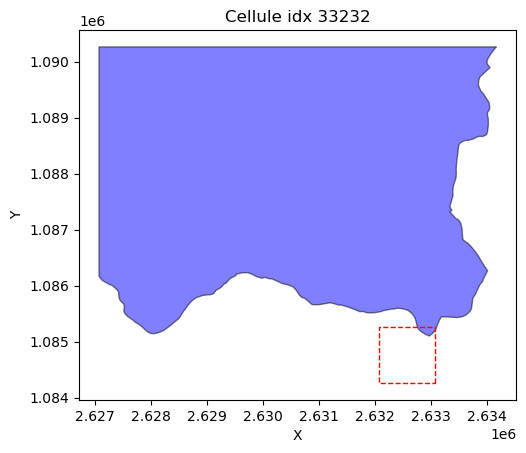

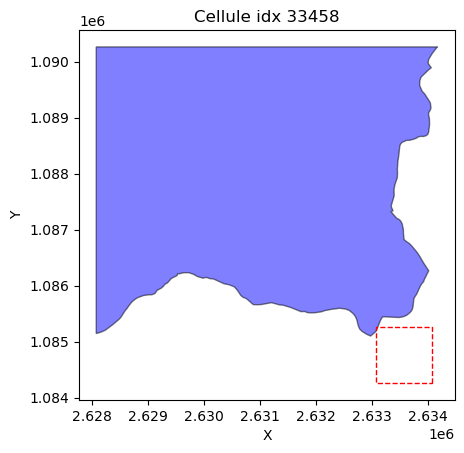

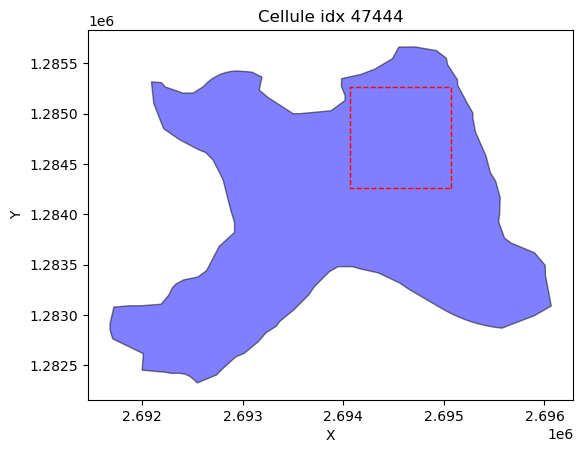

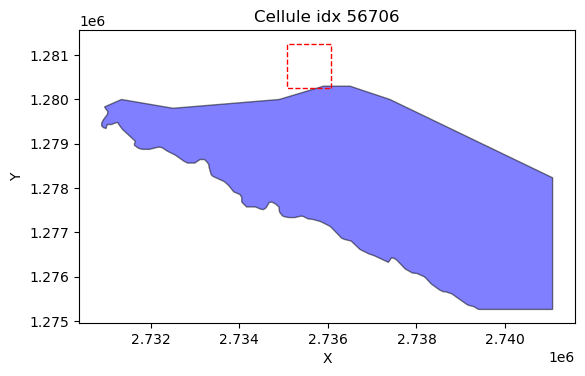

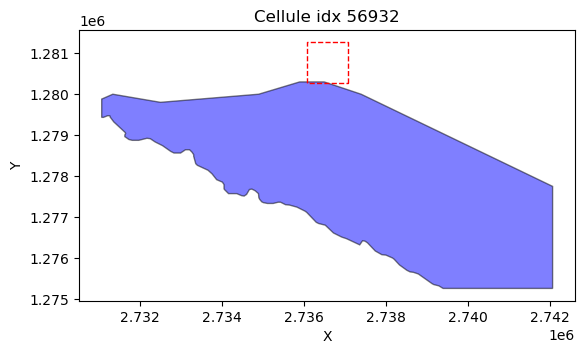

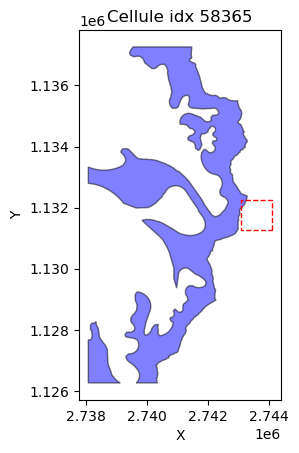

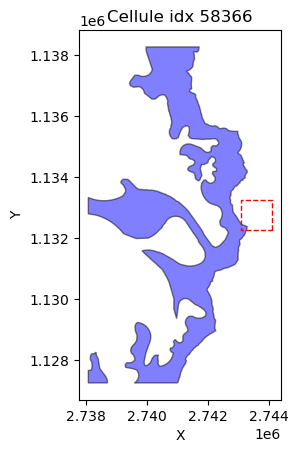

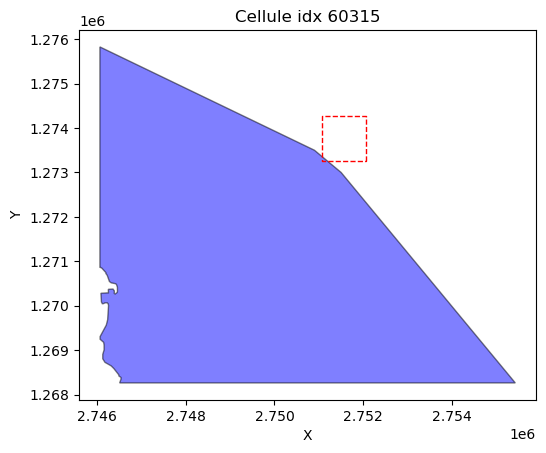

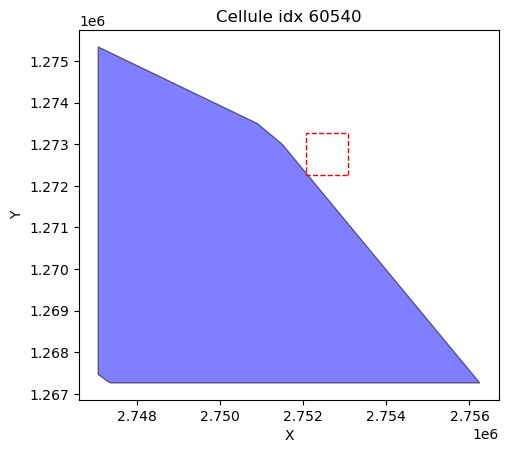

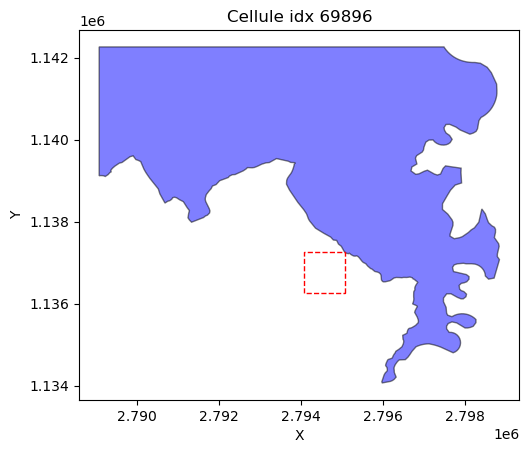

In [17]:
# Choix de la couche à importer dans le notebook
selected_layer = "Bodeneignungskarte"
gdb_path = "../../data/raw/Bodeneignungskarte_LV95.gdb"

# Itérer sur les entrées filtrées
overlap_areas = []
for idx, row in merged_gdf.loc[condition2].iterrows():
    # Recherche de la zone associée à la géométrie
    bbox = row['geometry'].bounds
    gdf_perma = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)

    # Définir la bounding box
    bbox_polygon = box(*bbox)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots()
    
    # Créer une bbox étendue pour garder une lecture lisible
    padding_value = 5_000
    expanded_bbox = (
       bbox[0] - padding_value, bbox[1] - padding_value, bbox[2] + padding_value, bbox[3] + padding_value
    )
    expanded_bbox_polygon = box(*expanded_bbox)
    
    # Ajouter chaque polygone (ou partie chevauchante) à l'axe
    for geom in gdf_perma['geometry']:
        intersection = geom.intersection(expanded_bbox_polygon)
        if not intersection.is_empty:
            if intersection.geom_type == 'Polygon':
                x, y = intersection.exterior.xy
                ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
            elif intersection.geom_type == 'MultiPolygon':
                for poly in intersection.geoms:
                    x, y = poly.exterior.xy
                    ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
    
    # Ajouter la bounding box à l'axe
    x, y = bbox_polygon.exterior.xy
    ax.plot(x, y, color='red', linewidth=1, linestyle='--')
    
    # Configurer l'affichage
    ax.set_title(f"Cellule idx {row['idx']}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    
    plt.show()

Les cellules sont bien en bordure de forme et peuvent donc être supprimées sans soucis. La seule cellule pouvant poser problème est celle possédant l'idx 47444, placée en milieu de géométrie. Comme expliqué précédemment, si l'on pointe cette cellule sur une carte, il s'agit en réalité d'une enclave allemande sur le territoire suisse, comme visible à [ce lien](https://map.geo.admin.ch/#/map?lang=fr&center=2690343.71,1283588.61&z=5.756&topic=ech&layers=ch.bafu.lebensraumkarte-schweiz;ch.blw.bodeneignung-wasserdurchlaessigkeit;ch.swisstopo.digitales-hoehenmodell_25_reliefschattierung,f;ch.swisstopo.swissboundaries3d-land-flaeche.fill&bgLayer=void&catalogNodes=ech,457). 

In [18]:
merged_gdf = merged_gdf.loc[~condition2]

### Cellules sans milieu naturel

Nous avons fait la distinction ici avec les cellules traitées précédemment, pour une raison de praticité lors de l'identification et du traitement des cellules.

Il reste donc encore une cellule pour laquelle il n'y a pas de valeur pour l'environnement. Celle-ci se situe dans le canton de Genève, à la limite du territoire. À nouveau, il s'agit ici d'une erreur due au manque d'un seuil minimal pour prendre en compte une cellule. La forme utilisée pour les aptitudes du sol déborde très légèrement sur la cellule en question, la faisant devenir valide. Il n'est donc pas nécessaire de la conserver.

In [19]:
condition3 = (
    merged_gdf['geometry_env_drop'].isnull()
)

In [20]:
merged_gdf.loc[condition3]

,idx,geometry,altitude,geometry_env_drop,TypoCH_NUM,geometry_apt_drop,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,geometry_tmp_drop,temperature
87,271,"POLYGON ((2486071.58 1119261.72, 2487071.58 11...",481.9648,None,NaN,"POLYGON ((2486071.58 1119261.72, 2487071.58 11...","eutric, gleyic, dystric, calcaric Cambisol; or...",5.0,4.0,6.0,"POLYGON ((2486071.58 1119261.72, 2487071.58 11...",4.8


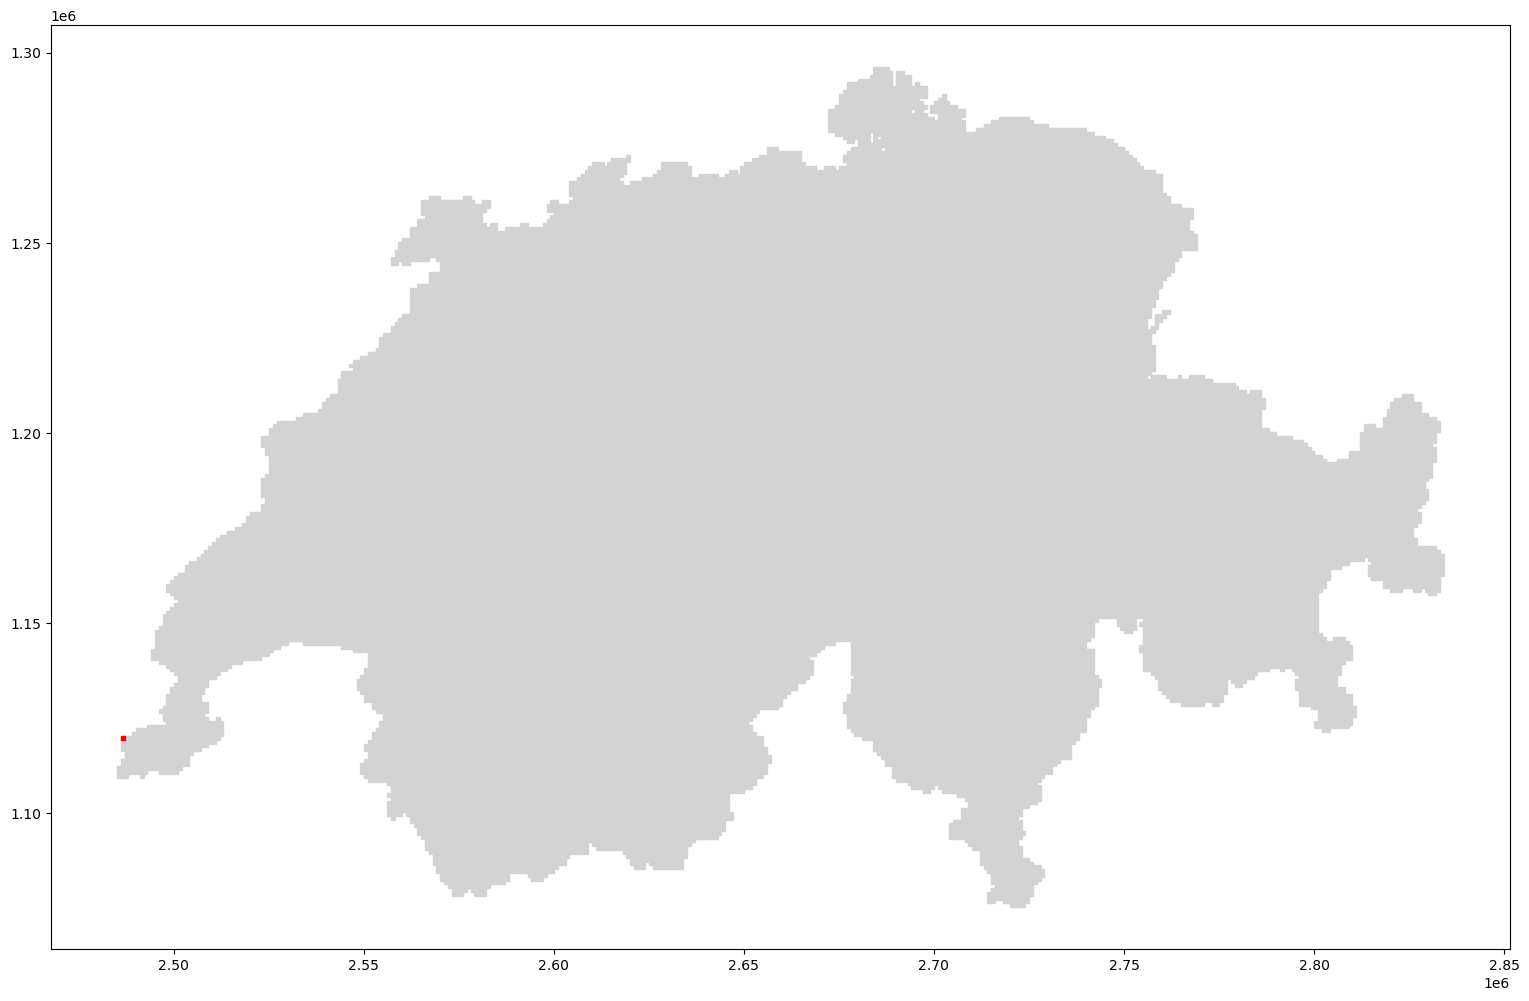

In [21]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition3].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

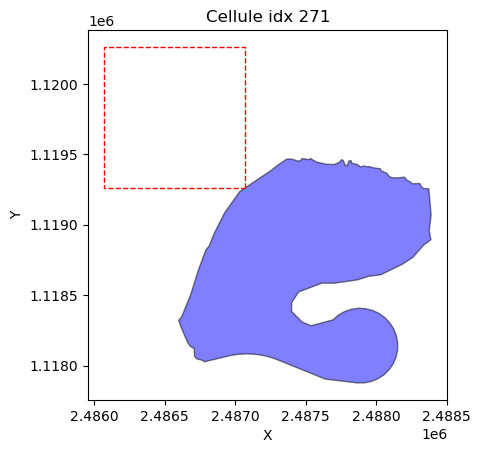

In [22]:
# Choix de la couche à importer dans le notebook
selected_layer = "Bodeneignungskarte"
gdb_path = "../../data/raw/Bodeneignungskarte_LV95.gdb"

row = merged_gdf.loc[condition3].iloc[0]

# Recherche de la zone associée à la geometrie
bbox = row['geometry'].bounds
gdf_perma = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)

# Définir la bounding box
bbox_polygon = box(*bbox)

# Créer une figure et un axe
fig, ax = plt.subplots()

# Ajouter chaque polygone à l'axe
for polygon in gdf_perma['geometry'][0].geoms:
    x, y = polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, fc='blue', ec='black')

# Ajouter la bounding box à l'axe
x, y = bbox_polygon.exterior.xy
ax.plot(x, y, color='red', linewidth=1, linestyle='--')

# Configurer l'affichage
ax.set_title(f"Cellule idx {row['idx']}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal', adjustable='box')

plt.show()


In [23]:
merged_gdf = merged_gdf.loc[~condition3]

### Cellules sans aptitudes du sol

Les dernières cellules à traiter sont celles n'ayant pas d'aptitudes du sol, pas même inconnues. Pour une partie de ces cellules, nous sommes à nouveau confrontés à un problème de seuil minimal pour prendre en compte une cellule. Les autres anomalies sont présentes à cause d'erreurs présentes dans le jeu de données brutes ainsi que par une définition des limites du territoire légèrement différentes.

In [24]:
condition4 = (
    merged_gdf['geometry_apt_drop'].isnull()    
)

In [25]:
merged_gdf.loc[condition4].shape[0]

37

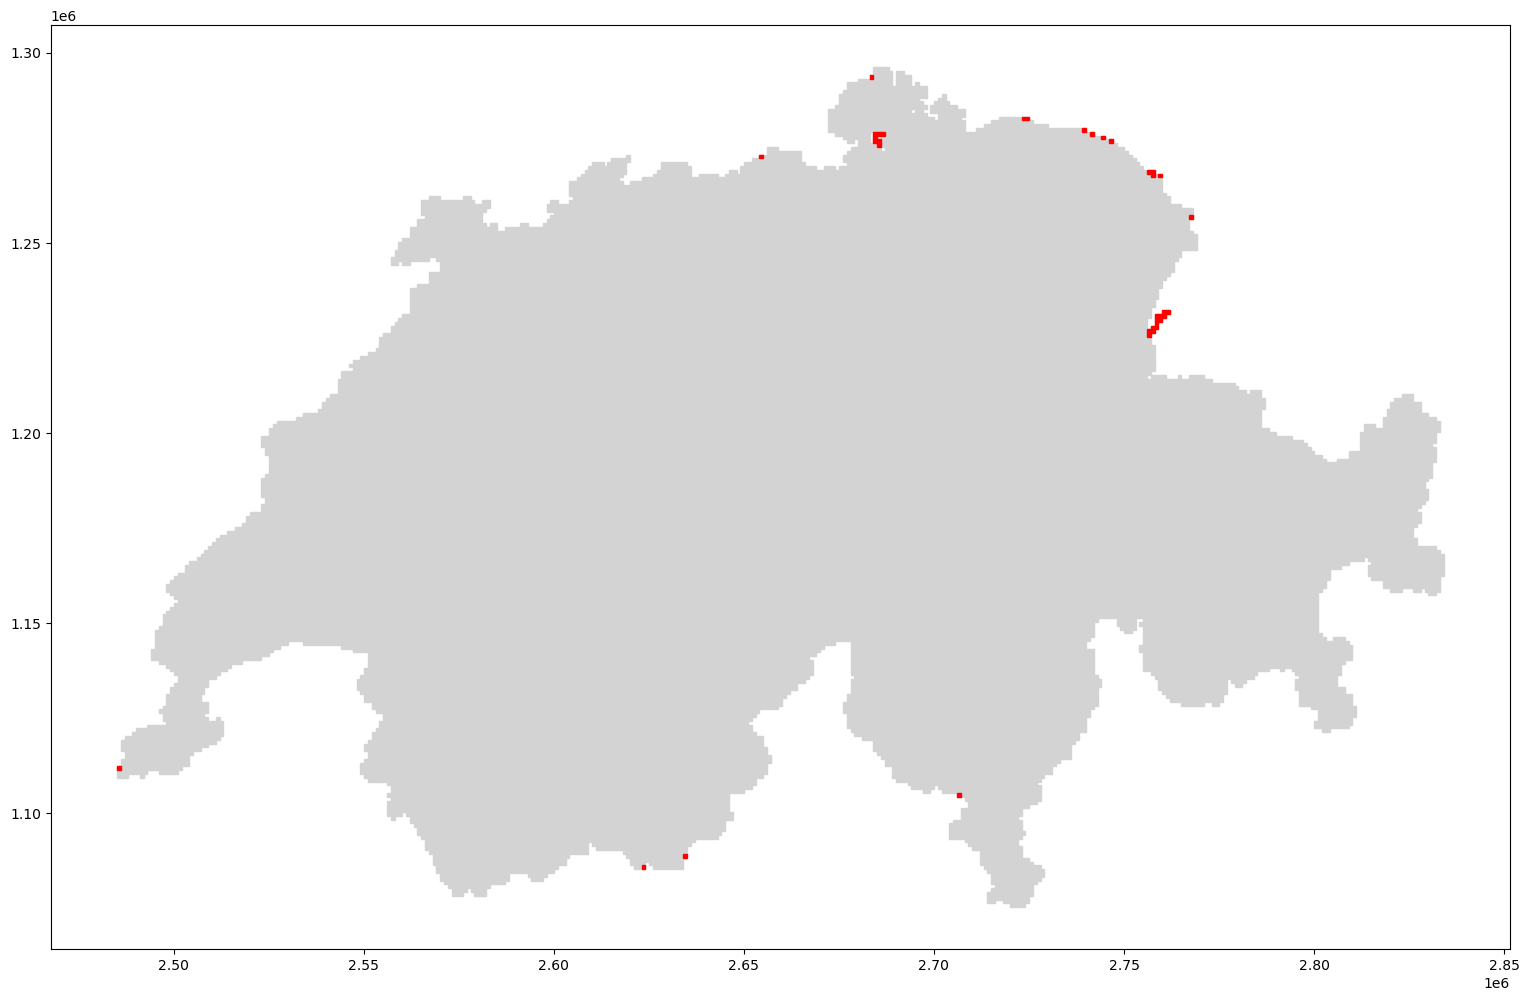

In [26]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition4].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

Nous allons traiter les cellules par type d'environnement, les uns après les autres, afin de garder une meilleure visibilité des graphiques. Des commentaires ne seront faits que lorsque nécessaire. Ainsi, toutes les cellules pouvant être supprimées, car prenant une part infime des géométries de base ne seront pas commentées et directement supprimées.

In [27]:
def print_graph_habitat_for_condition(condition) :
    base_path = '../../data/raw/splited_HabitatMap'
    file_prefix = 'HabitatMap_chunk'
    file_extension = '.gpkg'
    file_counter = 10
    
    # Choix de la couche à importer dans le notebook
    selected_layer = "HabitatMap_chunk"
    gdb_paths = [
        os.path.join(base_path, f"{file_prefix}{i}{file_extension}")
            for i in range(1, file_counter + 1)
    ]
    
    # Copier les entrées à traiter
    entries_to_process = merged_gdf.loc[condition].copy()
    remaining_entries = entries_to_process.index.tolist()
    
    # Itérer sur les différents chemins GDB
    for gdb_path in gdb_paths:    
        # Itérer sur les entrées restantes
        for idx in remaining_entries[:]:  # Copier la liste pour modification en place
            row = entries_to_process.loc[idx]
            
            # Recherche de la zone associée à la géométrie
            bbox = row['geometry'].bounds
            
            gdf = gpd.read_file(gdb_path, layer=selected_layer, bbox=bbox)
    
            if not gdf.empty:
                # Traiter l'entrée
                bbox_polygon = box(*bbox)
                
                # Créer une figure et un axe
                fig, ax = plt.subplots()

                # Créer une bbox étendue pour garder une lecture lisible
                padding_value = 5_000
                expanded_bbox = (
                   bbox[0] - padding_value, bbox[1] - padding_value, bbox[2] + padding_value, bbox[3] + padding_value
                )
                expanded_bbox_polygon = box(*expanded_bbox)
                
                # Ajouter chaque polygone (ou partie chevauchante) à l'axe
                for geom in gdf['geometry']:
                    intersection = geom.intersection(expanded_bbox_polygon)
                    if not intersection.is_empty:
                        if intersection.geom_type == 'Polygon':
                            x, y = intersection.exterior.xy
                            ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
                        elif intersection.geom_type == 'MultiPolygon':
                            for poly in intersection.geoms:
                                x, y = poly.exterior.xy
                                ax.fill(x, y, alpha=0.5, fc='blue', ec='black')
                
                # Ajouter la bounding box à l'axe
                x, y = bbox_polygon.exterior.xy
                ax.plot(x, y, color='red', linewidth=1, linestyle='--')
                
                # Configurer l'affichage
                ax.set_title(f"Cellule idx {row['idx']} (TypoCH: {row["TypoCH_NUM"]})")
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_aspect('equal', adjustable='box')
                
                plt.show()
                
                # Supprimer l'entrée de l'ensemble des entrées à traiter
                remaining_entries.remove(idx)

#### TypoCH 1x - Eaux libres

In [28]:
condition4_1x = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( (merged_gdf['TypoCH_NUM']  == 11.0) | (merged_gdf['TypoCH_NUM']  == 12.0) )
)

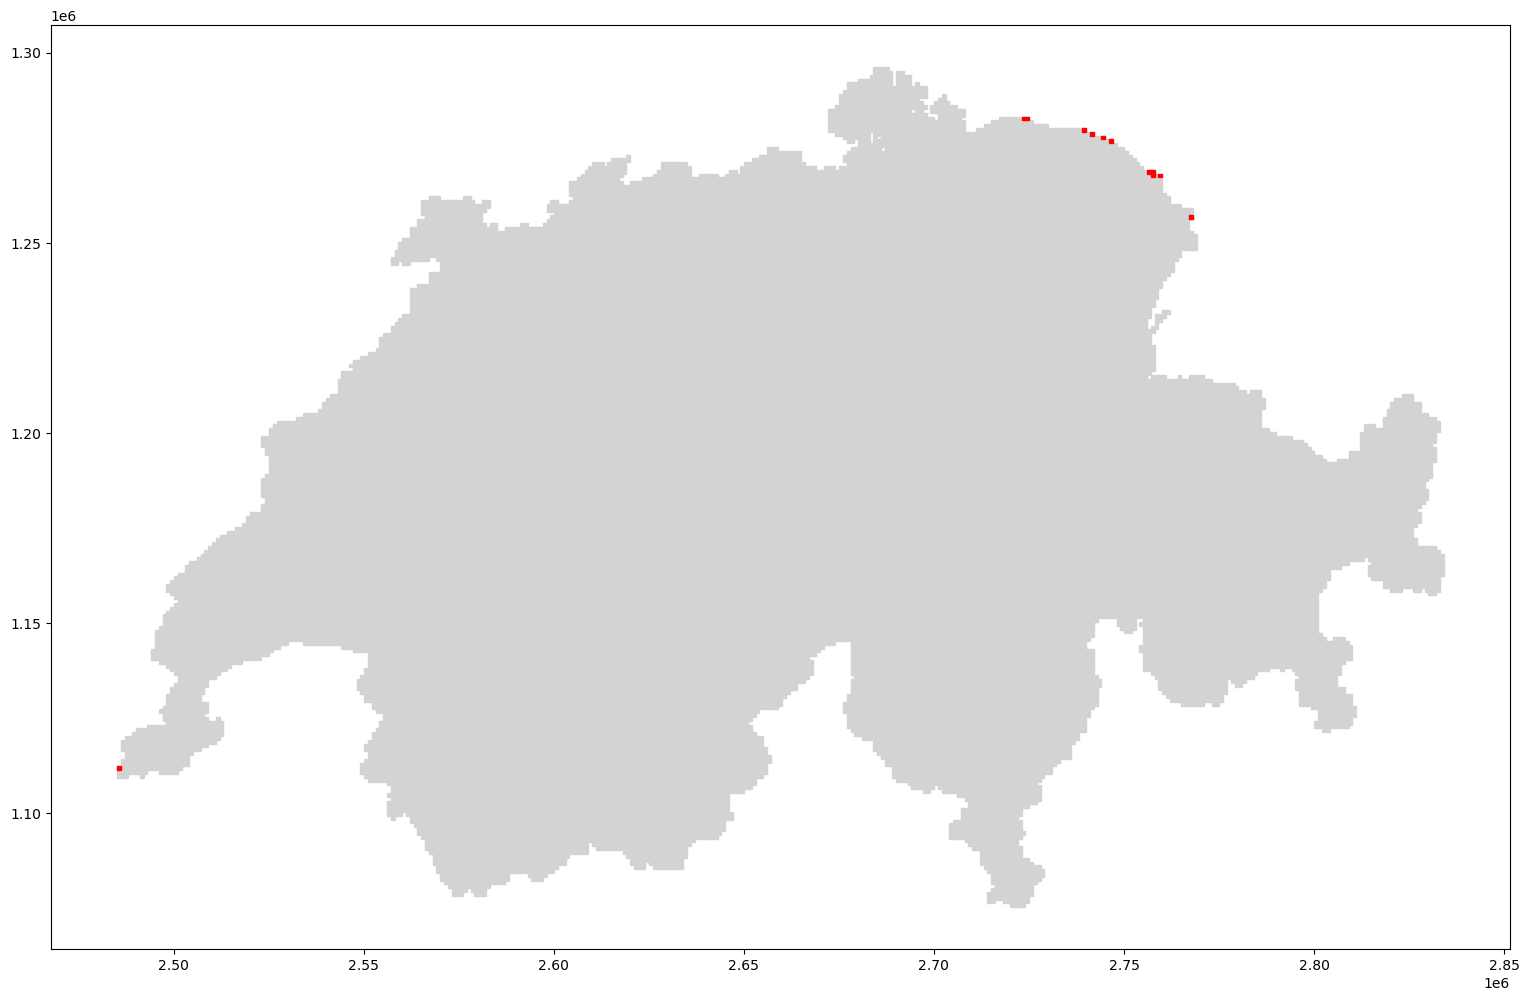

In [29]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition4_1x].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

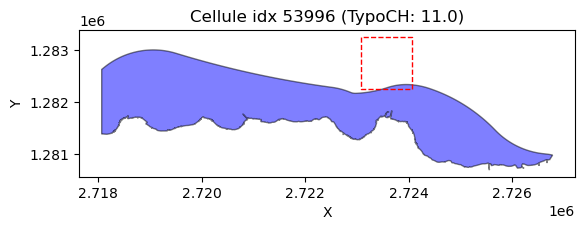

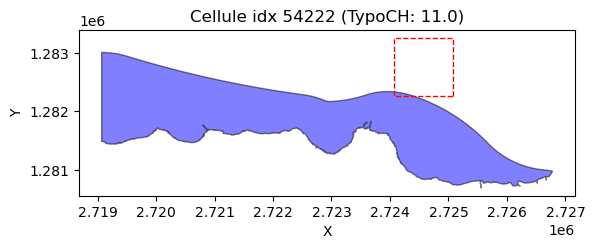

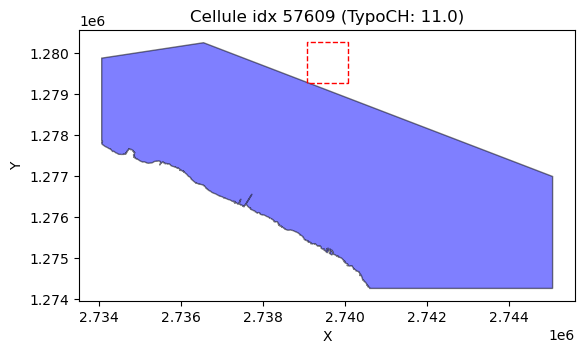

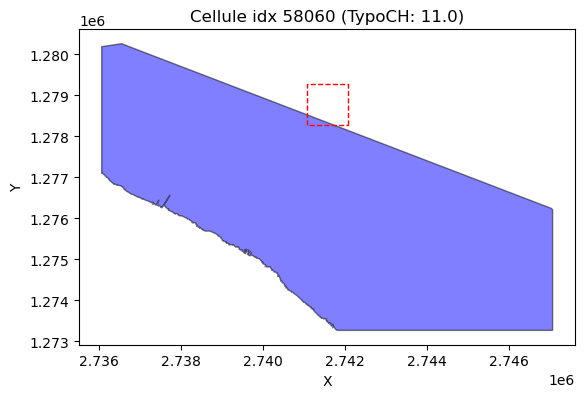

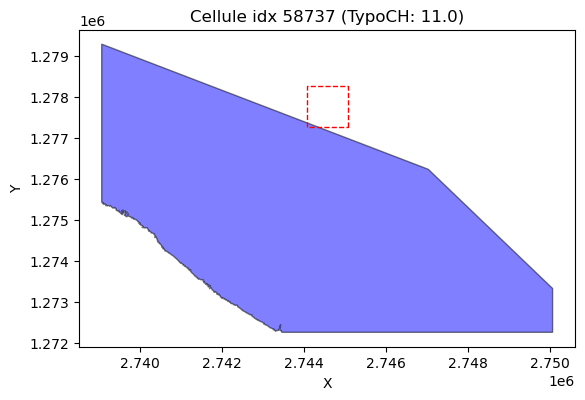

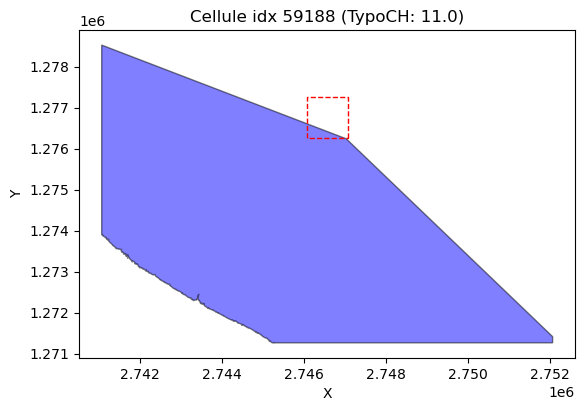

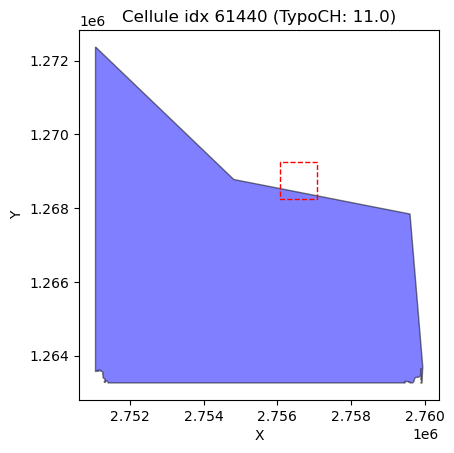

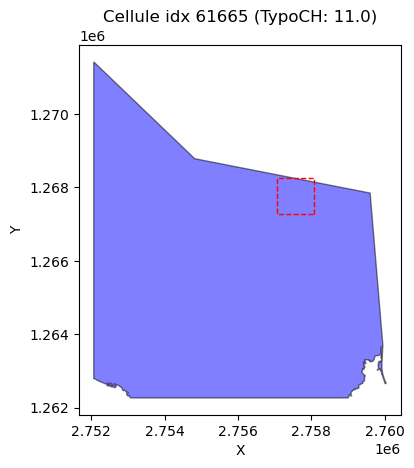

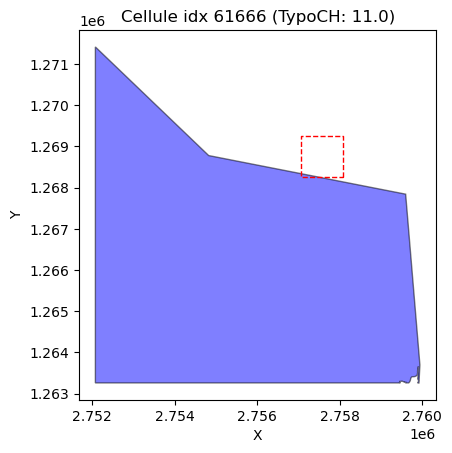

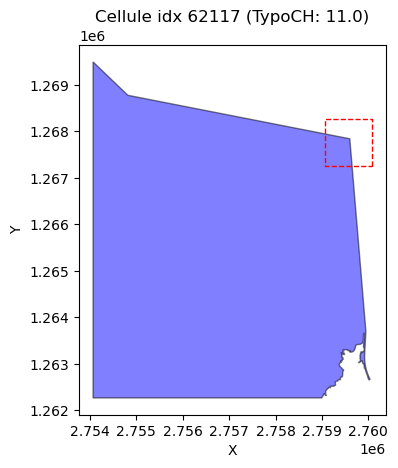

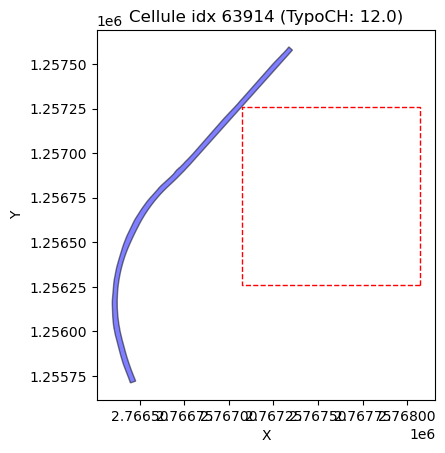

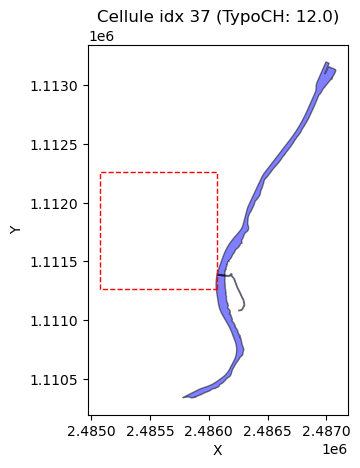

In [30]:
print_graph_habitat_for_condition(condition4_1x)

Malgré le fait que certaines cellules couvrent une infime partie des géométries d'origines, il a été décidé de les conserver en grande partie. En effet, les cellules concernées se trouvent au niveau du lac de Constance, à la limite entre la Suisse et l'Allemagne. Le fait de ne pas avoir de données sur les propriétés du sol ne sont pas pertinent, puisque difficile à consigner au fond de l'eau et peu pertinent sur la présence de notre plante. Ces cellules peuvent donc être complétées avec des données de valeurs inconnues.

Les cellules concernant les eaux courantes (TypoCH 12) seront par contre supprimées, celles-ci n'ayant qu'une infime partie de chevauchement avec la géométrie d'origine.

In [31]:
# Suppression des cellules concernées
condition4_12 = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( merged_gdf['TypoCH_NUM']  == 12.0 )
)

merged_gdf = merged_gdf.loc[~condition4_12]

#### TypoCH 31 - Glaciers, névés

In [32]:
condition4_31 = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( merged_gdf['TypoCH_NUM']  == 31.0 )
)

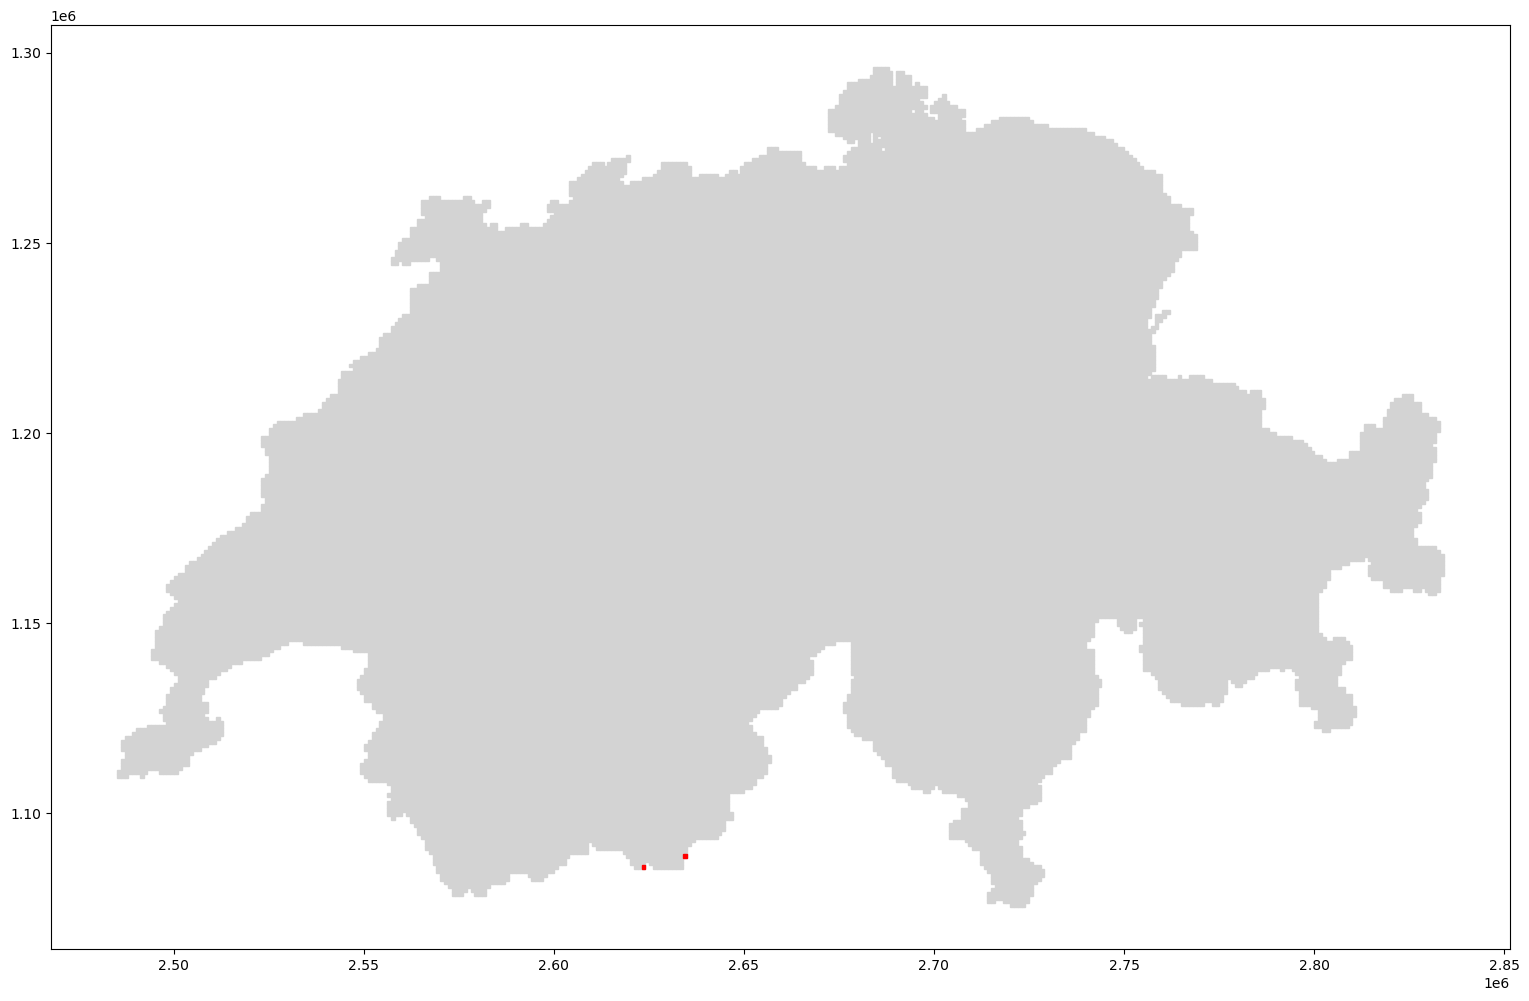

In [33]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition4_31].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

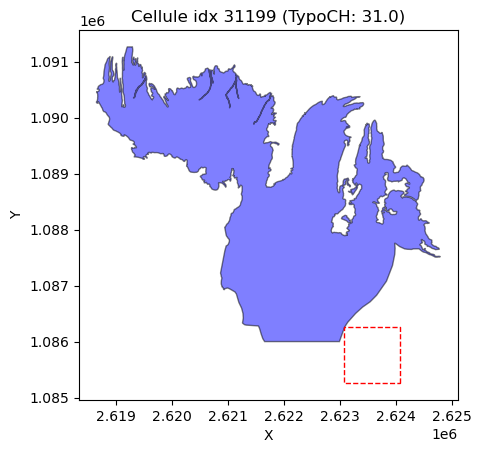

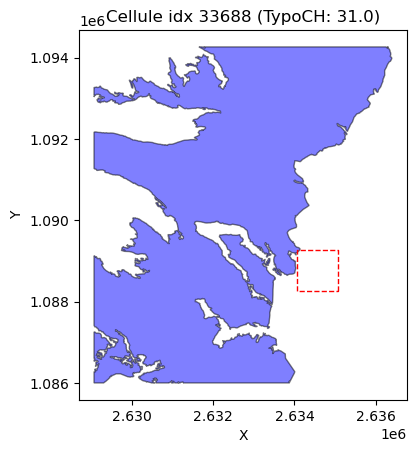

In [34]:
print_graph_habitat_for_condition(condition4_31)

In [35]:
merged_gdf = merged_gdf.loc[~condition4_31]

#### TypoCH 6x - Forêts

In [36]:
condition4_6x = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( (merged_gdf['TypoCH_NUM']  == 62.0) | (merged_gdf['TypoCH_NUM']  == 63.0) )
)

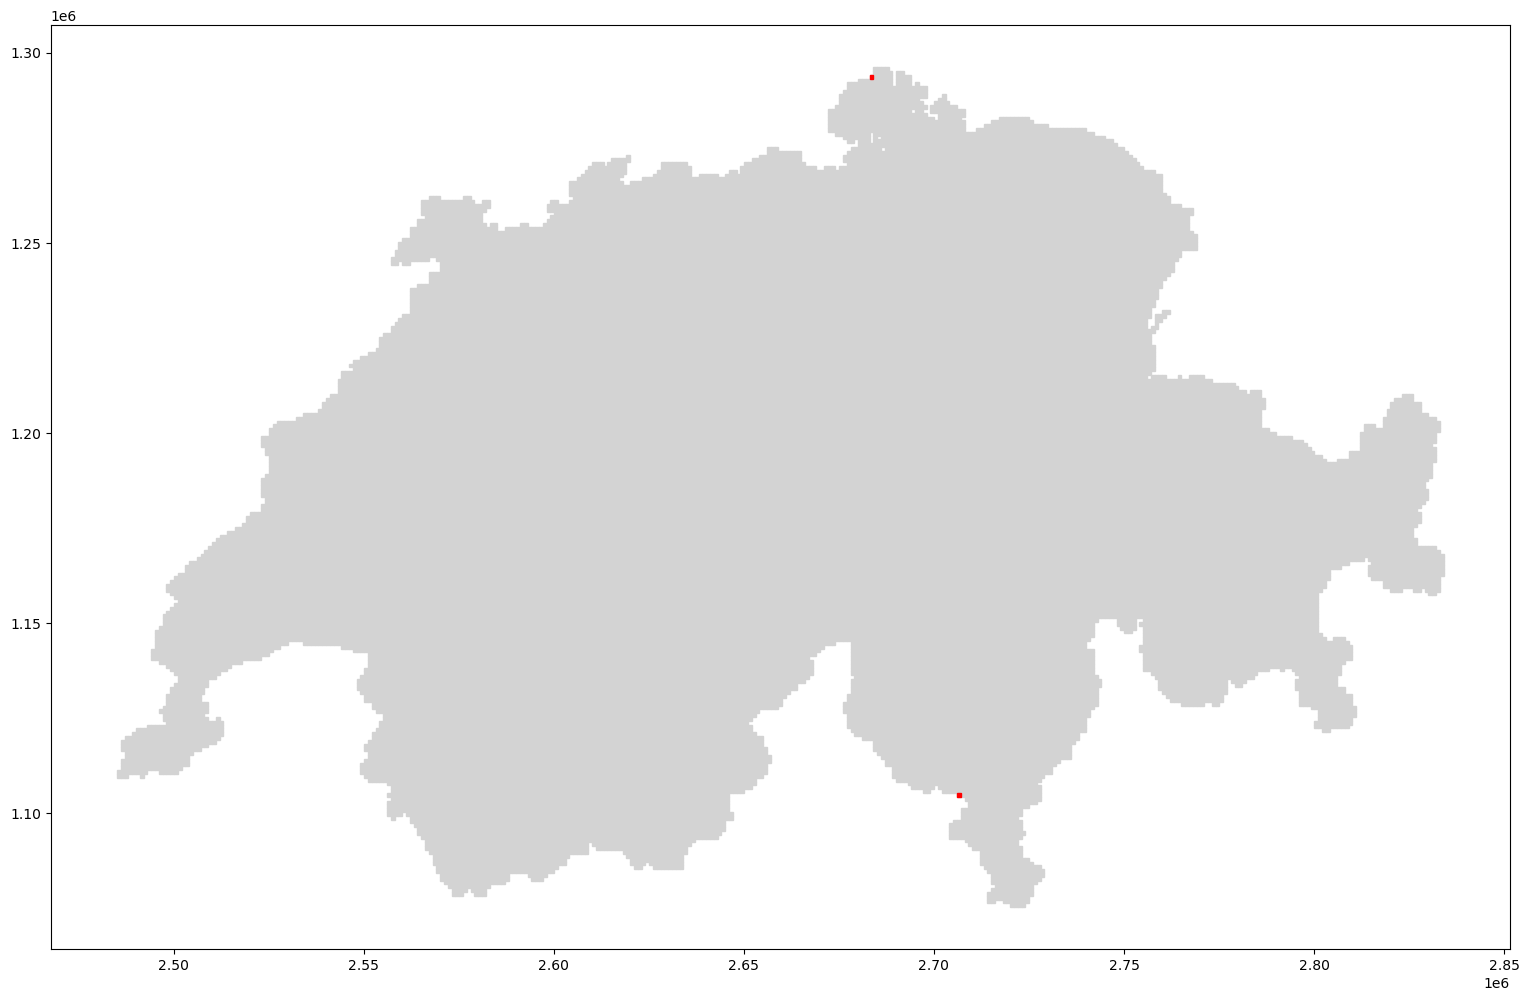

In [37]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition4_6x].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

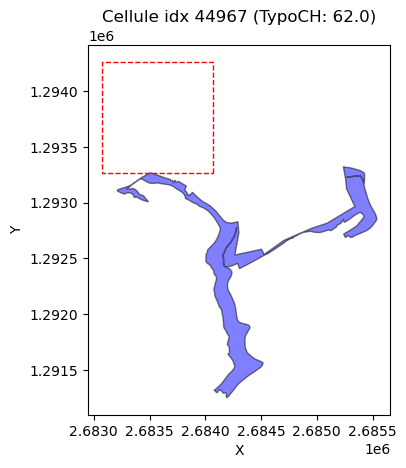

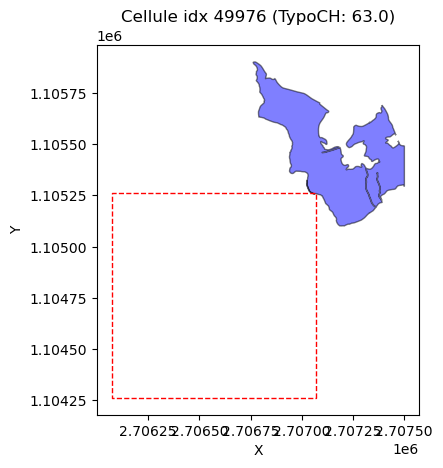

In [38]:
print_graph_habitat_for_condition(condition4_6x)

In [39]:
merged_gdf = merged_gdf.loc[~condition4_6x]

#### TypoCH 9x - Milieux construits

In [40]:
condition4_9x = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( (merged_gdf['TypoCH_NUM']  == 92.0) | (merged_gdf['TypoCH_NUM']  == 93.0) )
)

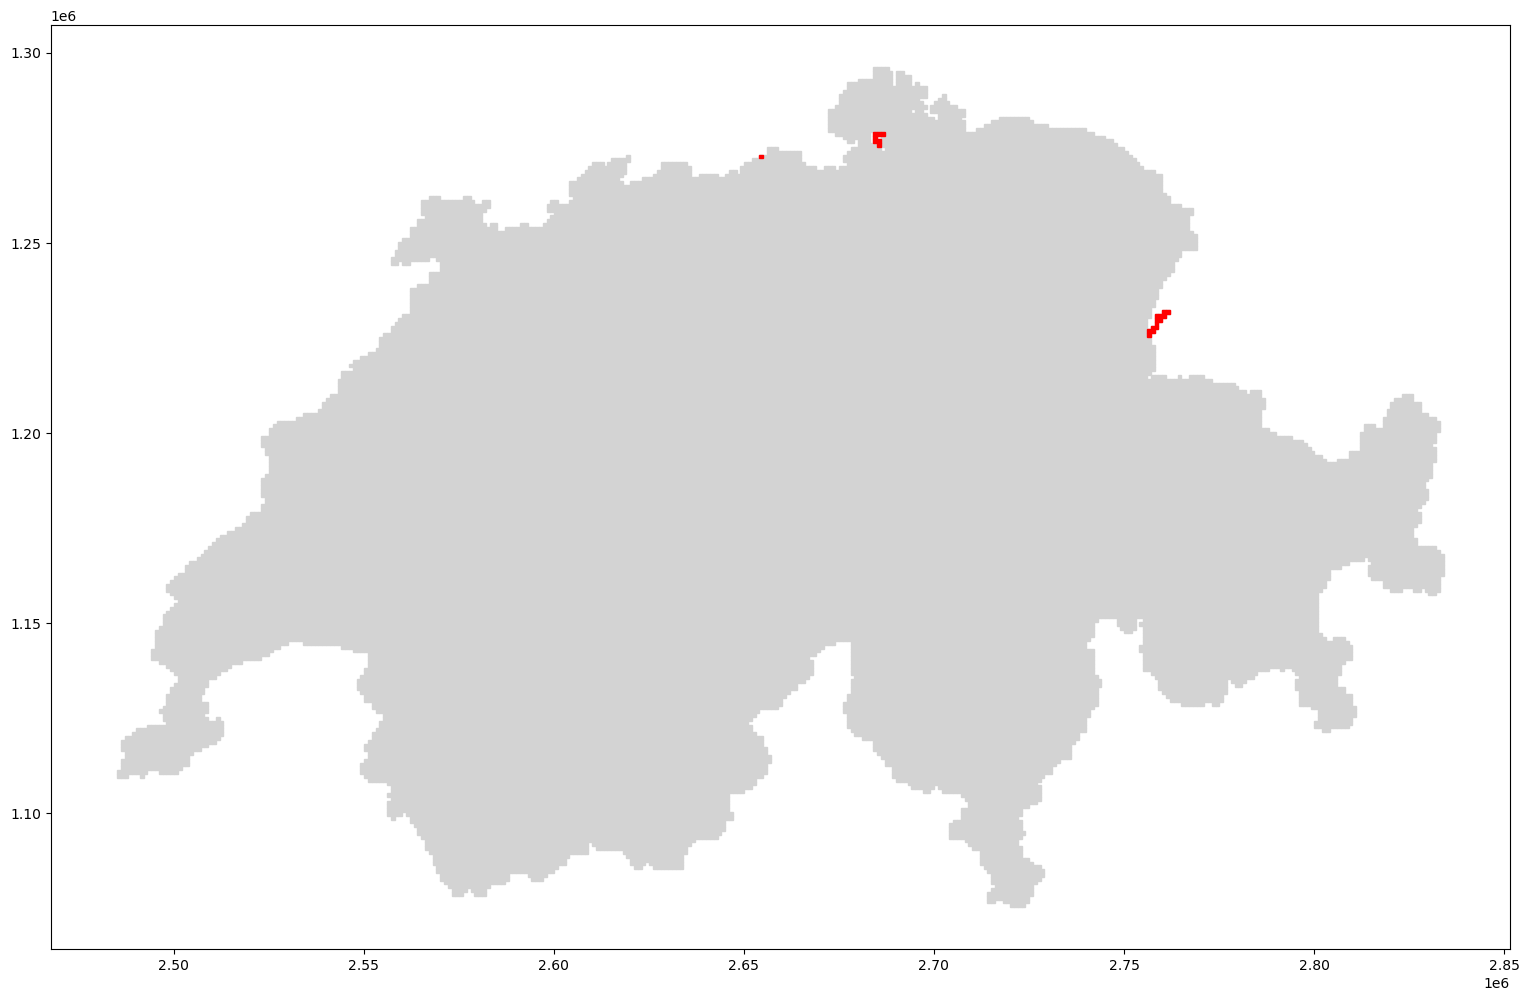

In [41]:
fig, ax = plt.subplots(figsize=(20, 12))

# Affichage des l'ensemble des données
for idx, row in merged_gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="lightgrey")

# Affichage des données à corriger
for idx, row in merged_gdf.loc[condition4_9x].iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    ax.fill(x, y, color="red")

ax.set_aspect('equal', adjustable='box')

# Afficher la figure
plt.show()

Les données étant séparées en zones distinctes, il a été décidé de les afficher par zones.

In [42]:
condition4_9x_left = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( (merged_gdf['TypoCH_NUM']  == 92.0) | (merged_gdf['TypoCH_NUM']  == 93.0) ) &
    (merged_gdf['geometry'].apply(lambda geom: geom.bounds[0] < 2.72e6))
)

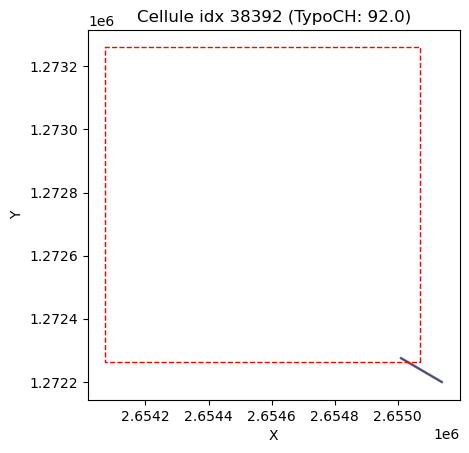

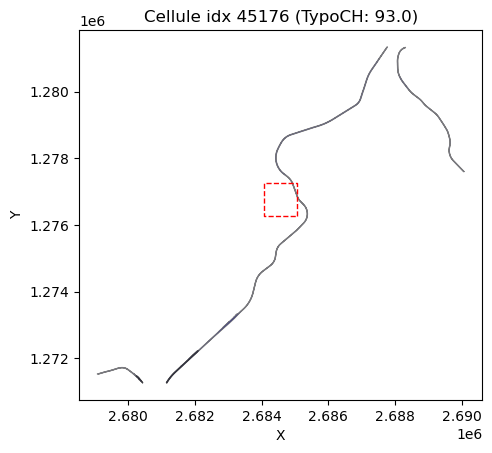

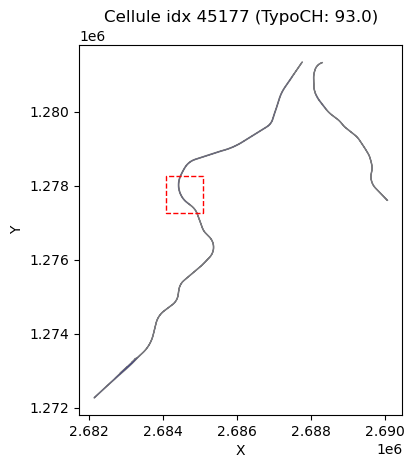

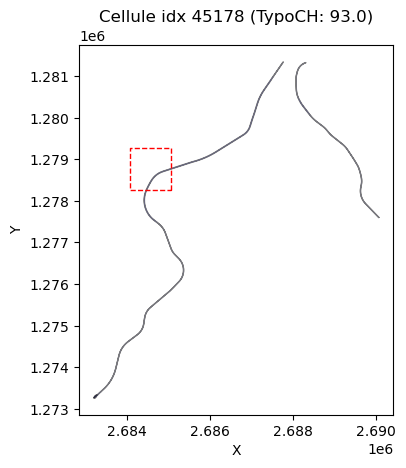

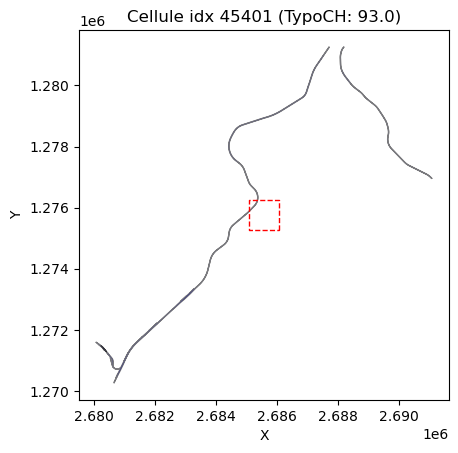

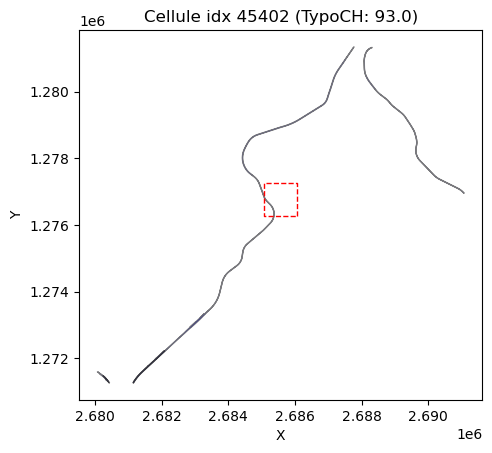

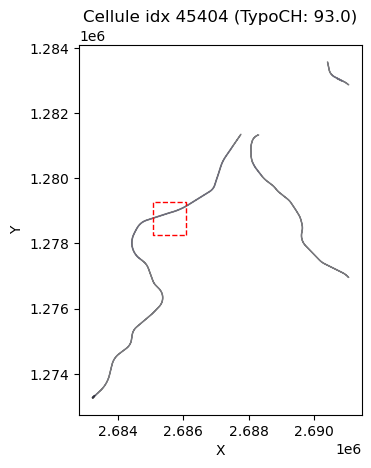

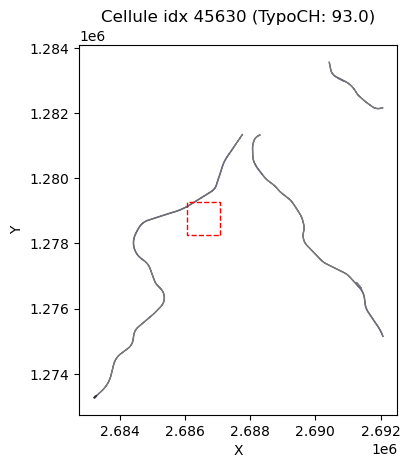

In [43]:
print_graph_habitat_for_condition(condition4_9x_left)

Les cellules ici sont voisines (à l'exception d'une seule) et suivent le tracé d'une route traversant l'Allemagne, au niveau de Lottstetten. Ce territoire n'est donc pas suisse et les cellules concernées peuvent être simplement supprimées de notre jeu de données.

La cellule solitaire sera, elle, supprimée, car n'ayant qu'une infime partie de chevauchement avec la géométrie d'origine, qui semble d'ailleurs être une erreur, au vue de sa taille.

In [44]:
condition4_9x_right = (
    merged_gdf['geometry_apt_drop'].isnull() &
    ( (merged_gdf['TypoCH_NUM']  == 92.0) | (merged_gdf['TypoCH_NUM']  == 93.0) ) &
    (merged_gdf['geometry'].apply(lambda geom: geom.bounds[0] > 2.72e6))
)

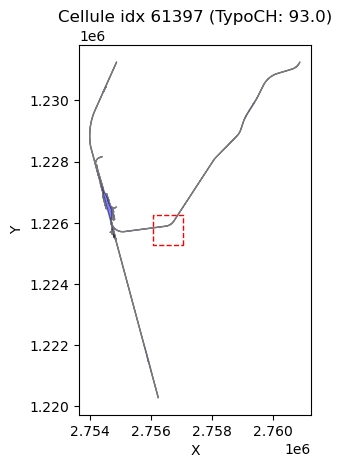

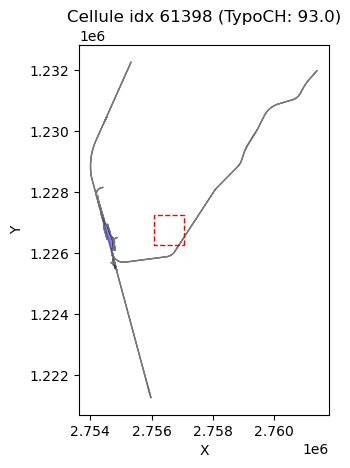

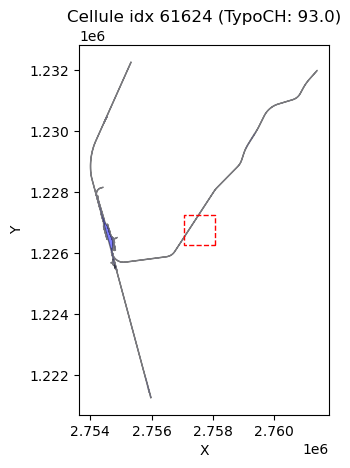

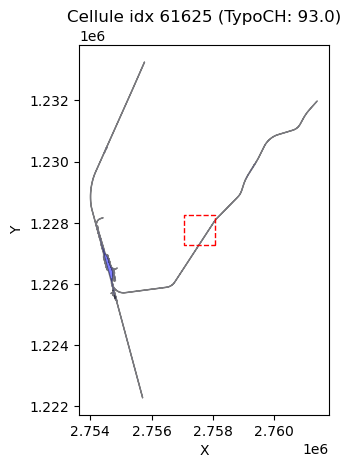

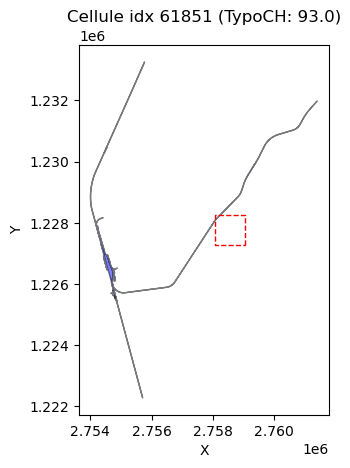

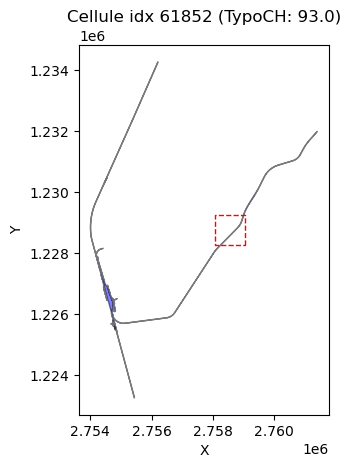

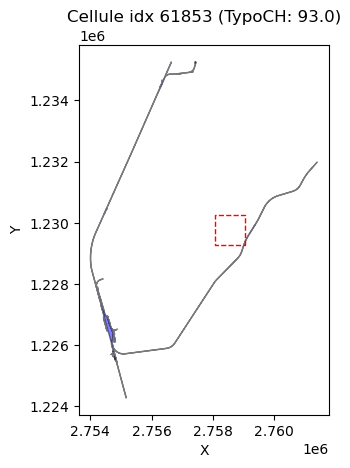

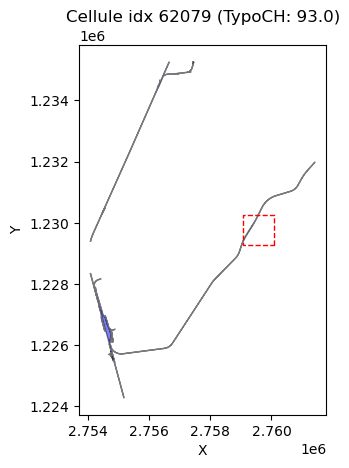

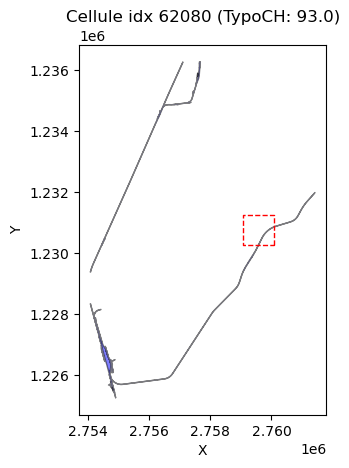

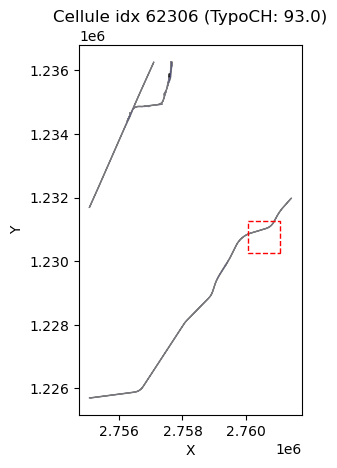

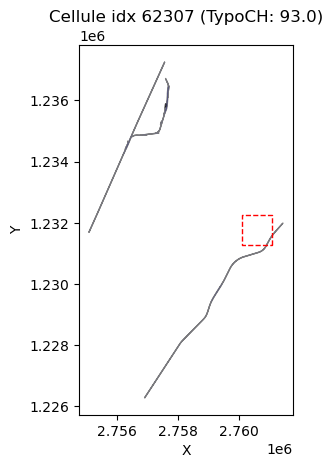

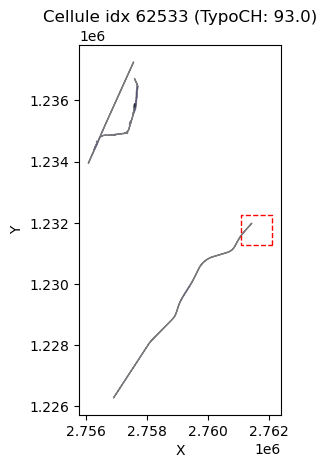

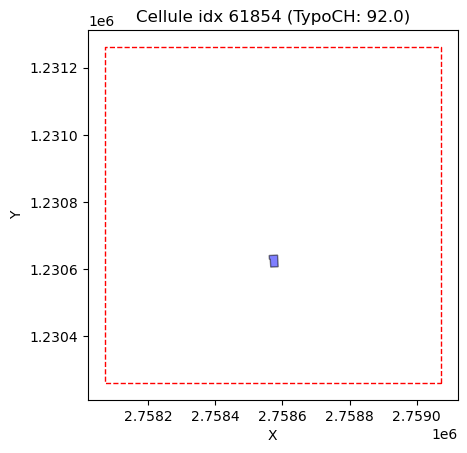

In [45]:
print_graph_habitat_for_condition(condition4_9x_right)

Les cellules ici sont également voisines et suivent à nouveau le tracé d'une route traversant l'Allemagne, mais cette fois-ci, en direction de Feldkirch. Ce territoire n'est donc, à nouveau, pas suisse et les cellules concernées peuvent être simplement supprimées de notre jeu de données.

In [46]:
merged_gdf = merged_gdf.loc[~condition4_9x]

#### Modification des données manquantes
Après observation des graphiques précédents, une partie des points a pu être supprimée, puisqu’à nouveau la non-présence d'un seuil a permis à ces cellules d'exister pour la majeure partie d'entre elles.

Le reste des données manquantes peuvent maintenant être remplie avec la valeur inconnue associée.

In [47]:
merged_gdf['Bodentyp'] = merged_gdf['Bodentyp'].fillna('-')
merged_gdf['NAHRSTOFF'] = merged_gdf['NAHRSTOFF'].fillna(0)
merged_gdf['WASSERDURC'] = merged_gdf['WASSERDURC'].fillna(0)
merged_gdf['WASSERSPEI'] = merged_gdf['WASSERSPEI'].fillna(0)

### Vérification finale

Pour la vérification finale, nous allons supprimer les colonnes de géométrie restantes et vérifier à nouveau si des valeurs manquantes existent.

In [48]:
def resolve_geometry_columns(merged_gdf):
    """Résout les colonnes de géométrie supplémentaires en vérifiant et en consolidant les géométries."""
    # Trouver toutes les colonnes de géométrie
    geometry_columns = [col for col in merged_gdf.columns if col.startswith('geometry')]

    if len(geometry_columns) > 1:
        # Processus pour vérifier et consolider les géométries
        merged_gdf['geometry'] = merged_gdf[geometry_columns].apply(lambda row: next((geom for geom in row if not pd.isnull(geom)), None), axis=1)
        # Supprimer les colonnes de géométrie supplémentaires
        merged_gdf = merged_gdf.drop(columns=[col for col in geometry_columns if col != 'geometry'])

    return merged_gdf

In [49]:
# Résoudre les colonnes de géométrie supplémentaires
resolved_gdf = resolve_geometry_columns(merged_gdf)

In [50]:
resolved_gdf[resolved_gdf.isnull().T.any()]

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,temperature


Notre jeu de données ne contient plus aucune donnée manquante après notre traitement !